<a href="https://colab.research.google.com/github/Jair2472/Proyecto_Prediccion_MargenBruto/blob/main/Modelo_XGBost_LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ==============================================================================
# ESTIMACIÓN DIARIA DE MARGEN BRUTO FINAL (ENFOQUE GLOBAL)
# ==============================================================================
# ==============================================================================
# MÓDULO 1: CONFIGURACIÓN INICIAL Y CARGA DE DATOS
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Herramientas y Modelos de Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Modelos avanzados que probaremos
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor

# --- Configuración de Estilo para Gráficos ---
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['figure.dpi'] = 100

print(">>> Módulo 1: Librerías cargadas y configuración lista.")

# --- Carga de Datos ---

try:
    # **ACCIÓN REQUERIDA:** Asegúrate de tener tu archivo 'dataset.csv' en la misma carpeta.
    df_raw = pd.read_csv('/content/250520_BD.csv', encoding='latin1')
    print("\n--- Datos cargados exitosamente desde 'dataset.csv' ---")

except FileNotFoundError:
    print("Error: 'dataset.csv' no encontrado. Por favor, asegúrate de que el archivo está en la misma carpeta que este script.")
    print("Usando datos simulados para continuar con la demostración...")

print("Dimensiones del dataset original:", df_raw.shape)
print("Primeras filas:")
print(df_raw.head())
print("\n" + "="*80 + "\n")

>>> Módulo 1: Librerías cargadas y configuración lista.

--- Datos cargados exitosamente desde 'dataset.csv' ---
Dimensiones del dataset original: (17528, 9)
Primeras filas:
   FiscalYear  Period   Date  Depto    VentasAcum    CostosAcum  IngresosAcum  \
0        2019       1  43402    123   25582.84437   6224.742985   -178.195595   
1        2019       1  43403    123   52294.89596  12551.411640   -211.506122   
2        2019       1  43404    123   75989.98114  17472.170950   -445.821574   
3        2019       1  43405    123  101996.77740  23246.260370   -820.099531   
4        2019       1  43406    123  130852.26790  29349.922940  -1185.005452   

   MargenFinal%  Ajuste  
0      0.200765     0.0  
1      0.200765     0.0  
2      0.200765     0.0  
3      0.200765     0.0  
4      0.200765     0.0  




In [ ]:
# ==============================================================================
# MÓDULO 2: LIMPIEZA Y PREPROCESAMIENTO INICIAL
# ==============================================================================

def limpiar_y_preprocesar_inicial(df):
    """
    Función que limpia los datos crudos y estandariza los tipos de datos.
    """
    print(">>> Módulo 2: Iniciando limpieza y preprocesamiento inicial...")

    df_limpio = df.copy()

    # --- Limpieza de Nombres de Columnas y Fechas ---
    df_limpio.columns = df_limpio.columns.str.strip()
    df_limpio['Fecha'] = pd.to_datetime(df_limpio['Date'], origin='1899-12-30', unit='D')

    # --- Renombrado para consistencia y claridad ---
    columnas_renombradas = {
        'FiscalYear': 'AnioFiscal',
        'Period': 'IdPeriodo',
        'Depto': 'IdDepto',
        'MargenFinal%': 'TARGET_MargenFinalPorc_Depto'
    }
    df_limpio.rename(columns=columnas_renombradas, inplace=True)

    # --- Verificación y Ajuste de Tipos de Datos ---
    df_limpio['AnioFiscal'] = df_limpio['AnioFiscal'].astype('int')
    df_limpio['IdPeriodo'] = df_limpio['IdPeriodo'].astype('int')
    df_limpio['IdDepto'] = df_limpio['IdDepto'].astype('int')

    # --- Ordenar los datos cronológicamente ---
    df_limpio.sort_values(by=['AnioFiscal', 'IdPeriodo', 'IdDepto', 'Fecha'], inplace=True)
    df_limpio.reset_index(drop=True, inplace=True)

    print("\n--- Limpieza completada ---")
    df_limpio.info()

    return df_limpio

df_limpio = limpiar_y_preprocesar_inicial(df_raw)
print("\n" + "="*80 + "\n")


>>> Módulo 2: Iniciando limpieza y preprocesamiento inicial...

--- Limpieza completada ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17528 entries, 0 to 17527
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   AnioFiscal                    17528 non-null  int64         
 1   IdPeriodo                     17528 non-null  int64         
 2   Date                          17528 non-null  int64         
 3   IdDepto                       17528 non-null  int64         
 4   VentasAcum                    17528 non-null  float64       
 5   CostosAcum                    17528 non-null  float64       
 6   IngresosAcum                  17528 non-null  float64       
 7   TARGET_MargenFinalPorc_Depto  17528 non-null  float64       
 8   Ajuste                        17528 non-null  float64       
 9   Fecha                         17528 non-null  datetime64[ns]
dtypes:

In [ ]:
# ==============================================================================
# MÓDULO 3: CREACIÓN DEL TARGET GLOBAL
# ==============================================================================
def creacion_target_global(df):
    print(">>> Módulo 3: Creando el Target Global...")

    columnas_numericas_agg = ['VentasAcum', 'CostosAcum', 'IngresosAcum', 'Ajuste']

    # 1. Obtenemos el último registro de cada periodo/departamento
    df_ultimos_dias_depto = df.loc[df.groupby(['AnioFiscal', 'IdPeriodo', 'IdDepto'])['Fecha'].idxmax()]

    # 2. Sumamos los totales de todos los departamentos para cada periodo
    df_totales_periodo = df_ultimos_dias_depto.groupby(['AnioFiscal', 'IdPeriodo'])[columnas_numericas_agg].sum().reset_index()

    # 3. Calculamos el margen final porcentual para cada periodo
    numerador = df_totales_periodo['VentasAcum'] + df_totales_periodo['IngresosAcum'] - df_totales_periodo['CostosAcum']
    denominador = df_totales_periodo['VentasAcum']
    df_totales_periodo['TARGET_MargenFinalPorc_Global'] = np.where(denominador != 0, numerador / denominador, 0)

    print("\n--- Target Global por periodo calculado ---")
    print(df_totales_periodo.head())

    return df_totales_periodo[['AnioFiscal', 'IdPeriodo', 'TARGET_MargenFinalPorc_Global']]

df_target_global = creacion_target_global(df_limpio)
print("\n" + "="*80 + "\n")


>>> Módulo 3: Creando el Target Global...

--- Target Global por periodo calculado ---
   AnioFiscal  IdPeriodo    VentasAcum    CostosAcum  IngresosAcum  \
0        2019          1  1.778322e+06  9.786161e+05 -71038.236778   
1        2019          2  1.944178e+06  1.087501e+06 -75060.307897   
2        2019          3  1.768838e+06  9.437344e+05 -61294.038282   
3        2019          4  1.757025e+06  9.465869e+05 -70452.217673   
4        2019          5  1.705103e+06  9.345533e+05 -66407.607253   

          Ajuste  TARGET_MargenFinalPorc_Global  
0  520103.432128                       0.409750  
1  565797.238029                       0.402029  
2  546401.057646                       0.431814  
3  525507.366277                       0.421159  
4  500891.136382                       0.412962  




In [ ]:
# ==============================================================================
# MÓDULO 4: INGENIERÍA DE CARACTERÍSTICAS
# ==============================================================================
def crear_features_basicas(df, df_target):
    print(">>> Módulo 4: Creando características...")

    df_featured = df.copy()

    # --- Unir el Target Global a cada día/departamento ---
    df_featured = pd.merge(df_featured, df_target, on=['AnioFiscal', 'IdPeriodo'], how='left')

    # --- Derivación de Montos Diarios por Departamento ---
    acum_cols = ['VentasAcum', 'CostosAcum', 'IngresosAcum']
    for col in acum_cols:
        df_featured[col.replace('Acum', 'Diario')] = df_featured.groupby(['AnioFiscal', 'IdPeriodo', 'IdDepto'])[col].diff().fillna(df_featured[col])

    # --- Feature Temporal Clave ---
    # 'DayOfPeriod', fue central en los análisis de tu equipo.
    df_featured['DiaDelPeriodo'] = df_featured.groupby(['AnioFiscal', 'IdPeriodo', 'IdDepto']).cumcount() + 1

    # --- Limpieza final de NaNs generados por el merge ---
    df_featured.dropna(subset=['TARGET_MargenFinalPorc_Global'], inplace=True)

    print("\n--- Ingeniería de Características completada ---")
    return df_featured

df_modelo = crear_features_basicas(df_limpio, df_target_global)
print("\n" + "="*80 + "\n")


>>> Módulo 4: Creando características...

--- Ingeniería de Características completada ---




In [ ]:
# --- División de Datos por Año (Entrenamiento y Prueba) ---
# Convertir la columna AnioFiscal a tipo numérico para poder hacer comparaciones
# anio_prueba = df_modelo['AnioFiscal'].cat.categories.max() # Esto causa error porque AnioFiscal es int, no category
anio_prueba = df_modelo['AnioFiscal'].max() # Obtener el año máximo directamente de la columna int

# Define features (X) and target (y)
features = ['IdDepto', 'VentasAcum', 'CostosAcum', 'IngresosAcum', 'Ajuste',
            'VentasDiario', 'CostosDiario', 'IngresosDiario', 'DiaDelPeriodo']
target = 'TARGET_MargenFinalPorc_Global'

X = df_modelo[features]
y = df_modelo[target]


# Asegurarse de que la comparación es numérica
idx_train = df_modelo[df_modelo['AnioFiscal'] < anio_prueba].index
idx_test = df_modelo[df_modelo['AnioFiscal'] == anio_prueba].index

if len(idx_test) == 0:
    print("ADVERTENCIA: No hay datos para el año de prueba. Usando división 80/20 como fallback.")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
else:
    X_train, X_test = X.loc[idx_train], X.loc[idx_test]
    y_train, y_test = y.loc[idx_train], y.loc[idx_test]

print(f"\nDatos de entrenamiento: {len(X_train)} filas")
print(f"Datos de prueba: {len(X_test)} filas")


# --- Creación del Pipeline de Preprocesamiento ---
columnas_categoricas = ['IdDepto']
columnas_numericas = X_train.select_dtypes(include=np.number).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        # No aplicamos transformador a las numéricas, las dejamos pasar.
        ('num', 'passthrough', columnas_numericas),
        # Codificamos la categórica.
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), columnas_categoricas)
    ],
    remainder='drop' # Ignoramos cualquier otra columna que no esté especificada
)

print("\n--- Preparación de datos completada ---")
print("\n" + "="*80 + "\n")


Datos de entrenamiento: 14616 filas
Datos de prueba: 2912 filas

--- Preparación de datos completada ---




In [ ]:
# --- Creación del Pipeline de Preprocesamiento ---
columnas_categoricas = ['IdDepto']
columnas_numericas = X_train.select_dtypes(include=np.number).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        # No aplicamos transformador a las numéricas, las dejamos pasar.
        ('num', 'passthrough', columnas_numericas),
        # Codificamos la categórica.
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), columnas_categoricas)
    ],
    remainder='drop' # Ignoramos cualquier otra columna que no esté especificada
)

print("\n--- Preparación de datos completada ---")
print("\n" + "="*80 + "\n")


# ==============================================================================
# MÓDULO 6: ENTRENAMIENTO DE MODELOS
# ==============================================================================
print(">>> Módulo 6: Entrenando modelos de Machine Learning...")

# --- Definición de Modelos ---
modelos = {
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42, n_jobs=-1),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42, n_jobs=-1)
}

# --- Entrenamiento de Modelos con Pipeline ---
pipelines = {}
for nombre, modelo in modelos.items():
    print(f"\nEntrenando {nombre}...")
    # Creamos un pipeline que primero preprocesa (codifica Depto) y luego entrena.
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', modelo)])
    pipeline.fit(X_train, y_train)
    pipelines[nombre] = pipeline
    print(f"{nombre} entrenado exitosamente.")

print("\n--- Entrenamiento de modelos completado ---")
print("\n" + "="*80 + "\n")


--- Preparación de datos completada ---


>>> Módulo 6: Entrenando modelos de Machine Learning...

Entrenando RandomForest...
RandomForest entrenado exitosamente.

Entrenando XGBoost...
XGBoost entrenado exitosamente.

Entrenando LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1766
[LightGBM] [Info] Number of data points in the train set: 14616, number of used features: 17
[LightGBM] [Info] Start training from score 0.376804


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM entrenado exitosamente.

--- Entrenamiento de modelos completado ---




>>> Módulo 7: Evaluando el rendimiento de los modelos...

--- Resultados para RandomForest ---
R-cuadrado (R²): -1.4081
Error Absoluto Medio (MAE): 0.0320 (o 3.20 puntos porcentuales)
MAE en Puntos Base (pb): 319.75 pb

--- Resultados para XGBoost ---
R-cuadrado (R²): -1.3898
Error Absoluto Medio (MAE): 0.0310 (o 3.10 puntos porcentuales)
MAE en Puntos Base (pb): 309.82 pb

--- Resultados para LightGBM ---
R-cuadrado (R²): -1.4136
Error Absoluto Medio (MAE): 0.0331 (o 3.31 puntos porcentuales)
MAE en Puntos Base (pb): 330.67 pb

--- Tabla Comparativa de Métricas ---
                    R2       MAE      MAE_pb
XGBoost      -1.389786  0.030982   309.81596
RandomForest -1.408147  0.031975  319.745615
LightGBM     -1.413575  0.033067  330.669489

Mejor modelo según MAE en Puntos Base: XGBoost


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


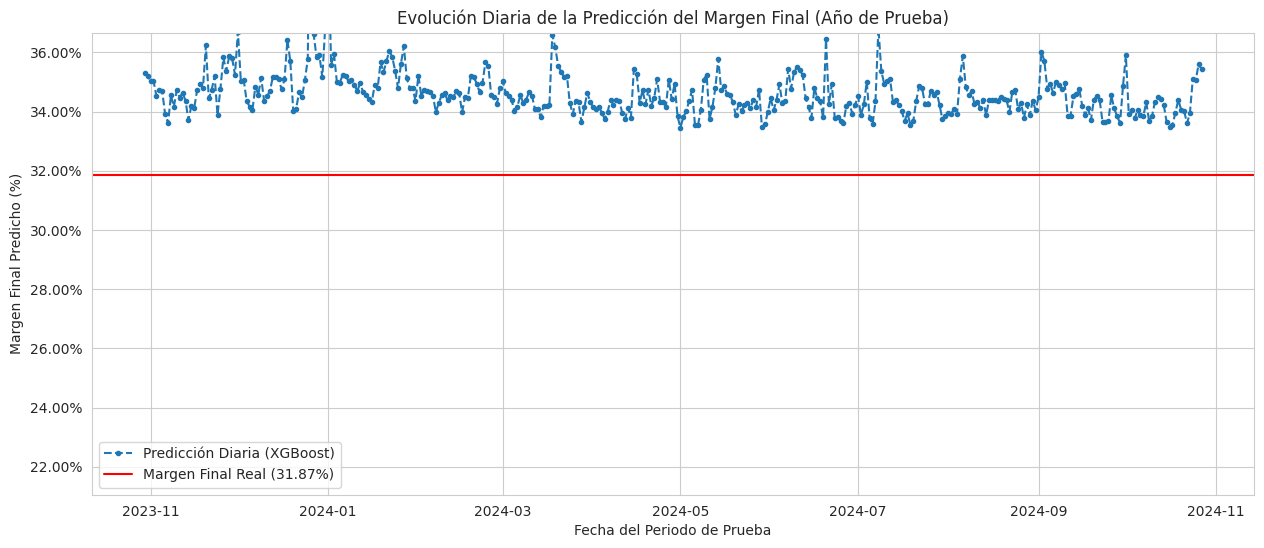


--- Evaluación de modelos completada ---




In [ ]:
# ==============================================================================
# MÓDULO 7: EVALUACIÓN DE MODELOS
# ==============================================================================
print(">>> Módulo 7: Evaluando el rendimiento de los modelos...")

resultados = {}
def evaluar_modelo_global(nombre, pipeline, X_test_df, y_test_series):
    if X_test_df.empty: return None
    y_pred = pipeline.predict(X_test_df)
    mae = mean_absolute_error(y_test_series, y_pred)
    r2 = r2_score(y_test_series, y_pred)
    mae_pb = mae * 10000

    print(f"\n--- Resultados para {nombre} ---")
    print(f"R-cuadrado (R²): {r2:.4f}")
    print(f"Error Absoluto Medio (MAE): {mae:.4f} (o {mae*100:.2f} puntos porcentuales)")
    print(f"MAE en Puntos Base (pb): {mae_pb:.2f} pb")

    return {'R2': r2, 'MAE': mae, 'MAE_pb': mae_pb, 'predictions': y_pred}

if not X_test.empty:
    for nombre, pipeline in pipelines.items():
        resultados[nombre] = evaluar_modelo_global(nombre, pipeline, X_test, y_test)

    df_resultados = pd.DataFrame(resultados).T.drop(columns='predictions')
    print("\n--- Tabla Comparativa de Métricas ---")
    print(df_resultados.sort_values(by='MAE_pb', ascending=True))

    mejor_modelo_nombre = df_resultados['MAE_pb'].idxmin()
    print(f"\nMejor modelo según MAE en Puntos Base: {mejor_modelo_nombre}")

    y_pred_mejor = resultados[mejor_modelo_nombre]['predictions']

    # --- ANÁLISIS VISUAL DE LA PREDICCIÓN DIARIA ---
    df_predicciones = pd.DataFrame({
        'Fecha': df_modelo.loc[y_test.index, 'Fecha'],
        'Real_Final': y_test,
        'Prediccion_Diaria': y_pred_mejor
    })

    # Agrupamos las predicciones diarias (promedio de todos los deptos para cada día)
    df_pred_global = df_predicciones.groupby('Fecha').mean().reset_index()

    plt.figure(figsize=(15, 6))
    plt.plot(df_pred_global['Fecha'], df_pred_global['Prediccion_Diaria'], label=f'Predicción Diaria ({mejor_modelo_nombre})', marker='.', linestyle='--')
    plt.axhline(y=df_pred_global['Real_Final'].iloc[0], color='r', linestyle='-', label=f'Margen Final Real ({df_pred_global["Real_Final"].iloc[0]:.2%})')
    plt.title(f'Evolución Diaria de la Predicción del Margen Final (Año de Prueba)')
    plt.ylabel('Margen Final Predicho (%)')
    plt.xlabel('Fecha del Periodo de Prueba')
    plt.legend()
    plt.ylim(bottom=df_pred_global['Real_Final'].min() * 0.95, top=df_pred_global['Real_Final'].max() * 1.05)
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter('{:.2%}'.format))
    plt.show()

else:
    print("\nNo se realizó evaluación por falta de datos de prueba.")

print("\n--- Evaluación de modelos completada ---")
print("\n" + "="*80 + "\n")


In [ ]:
# ==============================================================================
# MÓDULO 8: GUARDADO Y DESPLIEGUE
# ==============================================================================
print(">>> Módulo 8: Guardando el mejor modelo para producción...")

if not X_test.empty:
    mejor_pipeline = pipelines[mejor_modelo_nombre]
    joblib.dump(mejor_pipeline, f'{mejor_modelo_nombre}_pipeline_global.joblib')
    print(f"\nPipeline del modelo global '{mejor_modelo_nombre}' guardado como '{mejor_modelo_nombre}_pipeline_global.joblib'")
else:
    print("\nNo se guardó ningún modelo.")

print("\n--- Proceso de guardado completado ---")
print("\n" + "="*80 + "\n")